# Classification

For many datasets, learning and assessing classifiers requires 3-4 lines of code

105


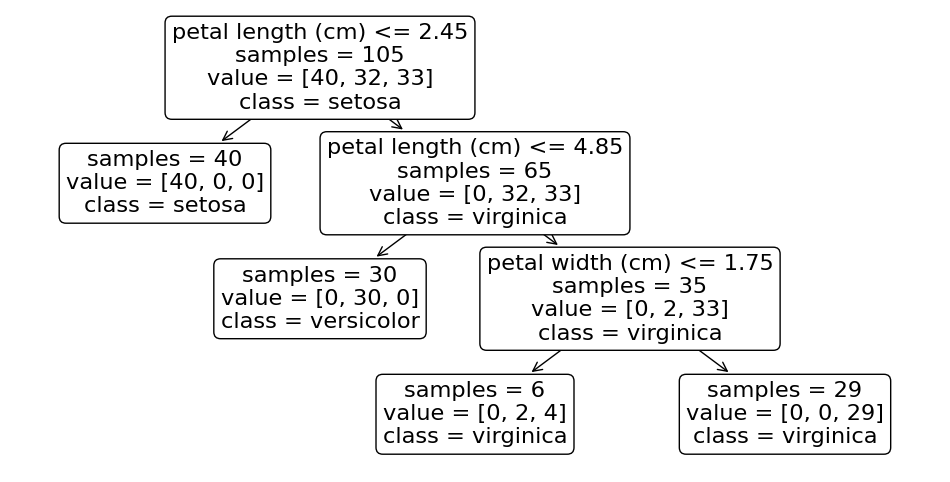

In [4]:
import matplotlib.pyplot as plt
from sklearn import metrics, datasets, tree
from sklearn.model_selection import train_test_split

# 1. load and partition data
iris = datasets.load_iris()
#print(iris.target)
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
print(X_train.__len__())

# 2. learn classifier
predictor = tree.DecisionTreeClassifier(max_depth=3)
predictor.fit(X_train, y_train)

# 3. plot classifier
figure = plt.figure(figsize=(12, 6))
tree.plot_tree(predictor, feature_names=iris.feature_names, class_names=iris.target_names, impurity=False, rounded=True)
plt.show()

In [5]:
# 4. test classifier
y_pred = predictor.predict(X_test)
print("accuracy on testing set:",  round(metrics.accuracy_score(y_test, y_pred),2))

accuracy on testing set: 0.89


In [6]:
single_pred = predictor.predict([X_test[0]])
print("prediction for instance",X_test[0],"is",iris.target_names[single_pred[0]])

prediction for instance [5.5 2.4 3.8 1.1] is versicolor


## 1) Data preparation

Nevertheless, many datasets are not well prepared for the straightforward learning of classifiers and thus require **preprocessing**.<br>
**Major steps**: missing imputation (see previous notebook), scaling of numeric vars, optional dummification of categorical vars (mandatory in *sklearn*)<br>
**Others**: data balancing, discretization of numeric vars, aggregation of categorical vars

**a) Loading** data

In [7]:
import pandas as pd, numpy as np

# read titanic data
df = pd.read_csv('titanic.csv')

# remove non relevant variables
df.drop(["PassengerId","Name","Ticket","Cabin"], axis = 1, inplace=True)

# remove observations with missings
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.25,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.925,S
3,1,1,female,35.0,1,0,53.1,S
4,0,3,male,35.0,0,0,8.05,S
...,...,...,...,...,...,...,...,...
707,0,3,female,39.0,0,5,29.125,Q
708,0,2,male,27.0,0,0,13,S
709,1,1,female,19.0,0,0,30,S
710,1,1,male,26.0,0,0,30,C


**b) Scaling** of numeric variables<br>Optional step, yet relevant for some predictive models (e.g., kNN)<br>Be careful: for classification purposes, scalers and imputers should be learned using training data only (see data sampling section)

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [26]:
# numeric variables [0,1]: problem with Fare variable?
df_scaled = df.copy()
df_scaled[['Age','Fare']] = MinMaxScaler().fit_transform(df[['Age','Fare']])
df_scaled.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,0.271174,1,0,0.014151,S
1,1,1,female,0.472229,1,0,0.139136,C
2,1,3,female,0.321438,0,0,0.015469,S
3,1,1,female,0.434531,1,0,0.103644,S
4,0,3,male,0.434531,0,0,0.015713,S


In [10]:
# numeric variables as N(0,1): minimizes Fare drawbacks
df_scaled[['Age','Fare']] = StandardScaler().fit_transform(df[['Age','Fare']])
df_scaled.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,-0.527669,1,0,-0.516380,S
1,1,1,female,0.577094,1,0,0.694046,C
2,1,3,female,-0.251478,0,0,-0.503620,S
3,1,1,female,0.369951,1,0,0.350326,S
4,0,3,male,0.369951,0,0,-0.501257,S


**c) Aggregation** (*Parch* ordinal variable can be optionally aggregated)

In [11]:
df['Parch'] = pd.to_numeric(df['Parch'])
df.value_counts("Parch")

Parch
0    519
1    110
2     68
3      5
5      5
4      4
6      1
dtype: int64

In [12]:
df[['Parch']] = df[['Parch']].apply(lambda x: [y if y < 2 else 3 for y in x])
df.value_counts("Parch")

Parch
0    519
1    110
3     83
dtype: int64

**d) Dummification** of categorical variables<br>Dummification is *optional* for binary variables

In [13]:
from sklearn.preprocessing import OneHotEncoder

# select columns to dummify
vars_to_dummify = ['Pclass','Parch','Embarked']
X = df[vars_to_dummify]

# dummify columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') #handle_unknown='ignore', sparse=False, dtype=bool)
trans_X = encoder.fit_transform(X)
new_vars = encoder.get_feature_names(vars_to_dummify)
print(new_vars)

['Pclass_1' 'Pclass_2' 'Pclass_3' 'Parch_0' 'Parch_1' 'Parch_3'
 'Embarked_C' 'Embarked_Q' 'Embarked_S']


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
# preprocess Age binary variable
df_dummified = df.copy()
df_dummified.replace({'female':0, 'male':1}, inplace=True)

# append dummified columns
df_dummified.drop(vars_to_dummify, axis = 1, inplace=True)
df_dummified[new_vars] = pd.DataFrame(trans_X, columns=new_vars)
df_dummified.head()

,Survived,Sex,Age,SibSp,Fare,Pclass_1,Pclass_2,Pclass_3,Parch_0,Parch_1,Parch_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,22.0,1,7.25,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0,38.0,1,71.2833,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,0,26.0,0,7.925,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1,0,35.0,1,53.1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0,1,35.0,0,8.05,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


## 2) Data sampling strategies for classification

In [15]:
# separate input from output data
X = df_dummified.drop('Survived', axis=1)
y = df_dummified['Survived']

### Hold-out strategy

Let us perform a simple data partition into train and test data (*train_test_split*) to learn and assess a simple decision tree

- *stratify* parameter in *train_test_split* ensures identical class distribution in train and test sets<br>
- optional *random_state* parameter can be used to fix partition to replicate results

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)
print("#training obs =",len(X_train),"\n#testing obs =",len(X_test))

#training obs = 498 
#testing obs = 214


In [17]:
# learn classifier using hold-out partitioning
predictor = tree.DecisionTreeClassifier()
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
print("Reference survivals:\n",y_test.tolist(),"\n\nPredicted survivals:\n",y_pred.tolist())
print("\nPredictor accuracy:",  round(metrics.accuracy_score(y_test, y_pred),2))

Reference survivals:
 [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1] 

Predicted survivals:
 [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1

### Cross-validation strategy

Cross-validation offers a more comprehensive evaluation, multiple estimates (variability, statistical tests)<br>
Two possibilities: a) predefined cross_eval_score utilities, b) manual fold iteration (useful for dedicated preprocessing)

In [18]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [19]:
# a) predefined capabilities

print("Fold accuracies:\n",cross_val_score(predictor, X, y, cv=10, scoring='accuracy'))

Fold accuracies:
 [0.65277778 0.72222222 0.78873239 0.8028169  0.8028169  0.76056338
 0.81690141 0.76056338 0.78873239 0.83098592]


In [20]:
# b) manual fold iteration

acc_folds = []
folds = StratifiedKFold(n_splits=10)

# iterate per fold
for train_k, test_k in folds.split(X, y):
    X_train, X_test = X.iloc[train_k], X.iloc[test_k]
    y_train, y_test = y.iloc[train_k], y.iloc[test_k]
    
    # train and assess
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    acc_folds.append(round(metrics.accuracy_score(y_test, y_pred),2))
    
print("Fold accuracies:", acc_folds)

Fold accuracies: [0.64, 0.75, 0.79, 0.8, 0.82, 0.79, 0.82, 0.77, 0.73, 0.85]


## 3) Classification models

This section provides a *high-level view* on how to instantiate different classification models.<br>
Please consult **sklearn documentation** for details on the parameterization and visualization of these predictors.

**a) Simple comparison** on the prepared dataset

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

classifiers = [
    ("Decision Tree", DecisionTreeClassifier(max_depth=5)),
    ("kNN", KNeighborsClassifier(n_neighbors=3)),
    ("Naive Bayes", GaussianNB()),
    ("Neural Network", MLPClassifier(alpha=1, max_iter=1000)),
    ("Linear SVM", SVC(kernel="linear", C=0.025))
]

In [22]:
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

In [23]:
for name, classifier in classifiers:
    accs = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
    print(name, "accuracy =", round(np.mean(accs),2), "±", round(np.std(accs),2))

Decision Tree accuracy = 0.79 ± 0.05
kNN accuracy = 0.69 ± 0.04
Naive Bayes accuracy = 0.78 ± 0.06
Neural Network accuracy = 0.8 ± 0.06
Linear SVM accuracy = 0.78 ± 0.03


**b) Visualizing boundaries** in bivariate numeric data

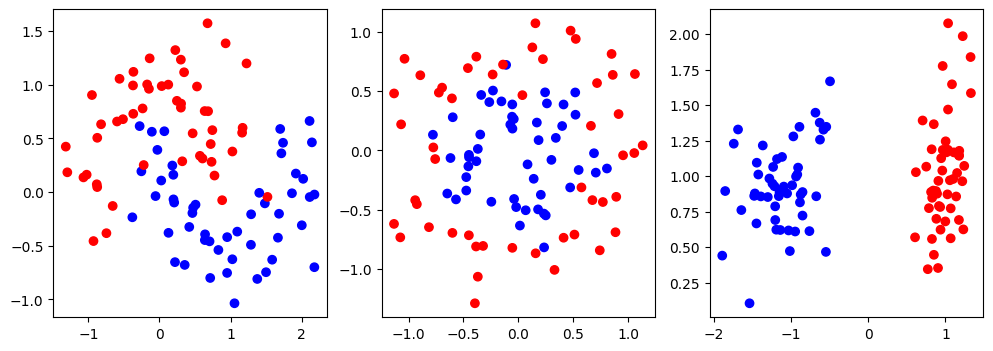

In [24]:
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification

# generate three bivariate datasets
datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
]

# plot the datasets
figure = plt.figure(figsize=(12, 4))
i = 1
for ds in datasets:
    X, y = ds
    ax = plt.subplot(1, 3, i)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']))
    i += 1

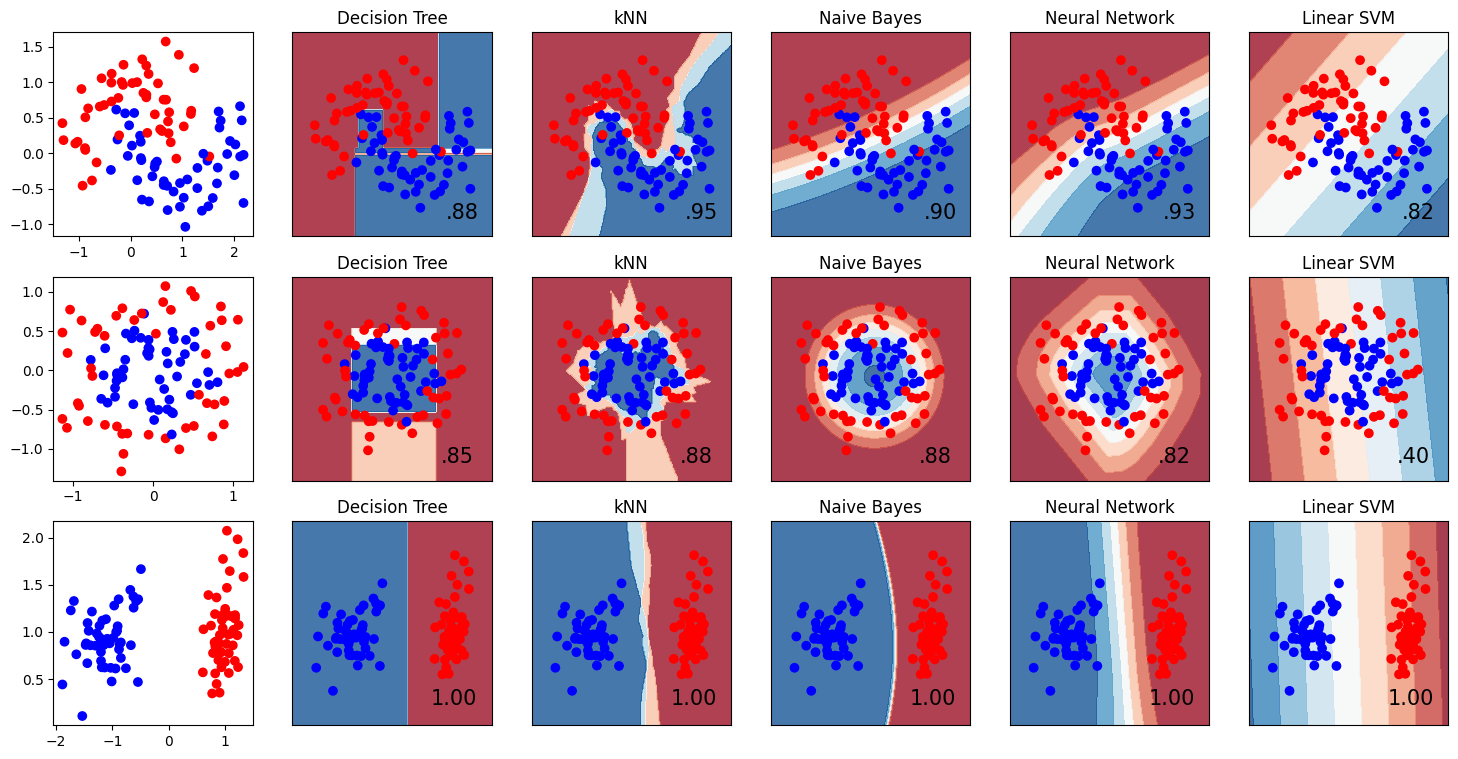

In [25]:
# Goal: draw the classification boundaries
i, colors = 1, ListedColormap(['#FF0000', '#0000FF'])
figure = plt.figure(figsize=(18, 9))

# 1. iterate over datasets
for ds in datasets:
    X, y = ds
    
    # 1a. plot the dataset
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)
    i += 1

    # 1b. split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    
    # 1c. record plot limits
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

 
    # 2. iterate over classifiers
    for name, clf in classifiers:
        
        # 2a. learn and apply classifier
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        
        # 2b. plot classification boundary
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if hasattr(clf, "decision_function"): Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else: Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
        i += 1

plt.show()